In [23]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward (generic function with 1 method)

# Compressed sensing

Consider the 200-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. The forward model $G \in R^{20 \times 200}$ is a random Gaussian matrix


   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

In [83]:

function aug_prediction(y, θ)
    return [y; sqrt.(abs.(θ))]
    # return [y; θ]
end

function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return aug_prediction(G * θ, θ)
end

function Compressed_Sensing()
    
    N_y, N_θ, N_nonzero = 20, 40, 10
    θ0_bar = zeros(Float64, N_θ)  # mean 
    
    Random.seed!(123);
    G = rand(Normal(0, 1), N_y, N_θ)
    
    θ_ref = zeros(Float64, N_θ)
    θ_ref[rand(1:N_θ, N_nonzero)] .= 1
    
    y = G*θ_ref
    Σ_η = Array(Diagonal(fill(0.01^2, size(y))))


    return θ_ref, G, y, Σ_η
end

Compressed_Sensing (generic function with 2 methods)

## Unscented Kalman Inversion

When the unscented Kalman inversion is applied with $\theta_0 \sim \mathcal{N}(0, 0.5^2I)$, 
the convergence of the $\theta$ for all three scenarios are depicted, in terms of the $L_2$ error $\lVert m_n - \theta_{ref}\rVert_2$ 
Exponential convergence is achieved!

In [89]:
FT = Float64

α_reg = 1.0
update_freq = 1
N_iter = 200

    
θ_ref, G, y, Σ_η = Compressed_Sensing()
    
N_θ = length(θ_ref)
N_y = length(y)

# augmented system
s_param = Setup_Param(G, N_θ, N_y + N_θ)
θ0_mean = zeros(FT, N_θ)
θ0_mean = uki_objs.θ_mean[end]
# θ0_mean = copy(θ_ref)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
λ_cov = Array(Diagonal(fill(0.1^2, N_θ)))*10
aug_y = aug_prediction(y, θ0_mean)  
aug_Σ_η = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  λ_cov]

    
uki_objs = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    aug_y, aug_Σ_η,
    α_reg,
    update_freq,
    N_iter);
    
    


┌ Info: ("optimization error at iter 1 = ", 0.0010853153492138296)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 6.324555320336759)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 9.285351065397609e-7)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 8.907389458142985)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 3.1743974088245527e-6)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 13.84394111364384)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 1.9157513886956144e-5)
└ @ Main /

┌ Info: ("optimization error at iter 38 = ", 46.151010704427954)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 38 = ", 28.22084489201231)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 39 = ", 66.07661060671106)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 39 = ", 25.032575854681195)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 40 = ", 81.35327315038728)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 40 = ", 22.876707073198464)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 41 = ", 48.92019608025483)
└ @ Main /Users

┌ Info: ("optimization error at iter 80 = ", 27.070847613030598)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 80 = ", 12.69049475637393)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 81 = ", 29.54991338488161)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 81 = ", 14.889692247690983)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 82 = ", 26.05643179644315)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 82 = ", 14.820565386139297)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 83 = ", 24.616898778028325)
└ @ Main /User

┌ Info: ("optimization error at iter 125 = ", 13.529614637465412)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 125 = ", 10.833697617429374)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 126 = ", 14.230495262067091)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 126 = ", 13.789554332722751)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 127 = ", 14.624221597801474)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 127 = ", 17.740594305519984)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 128 = ", 15.795261433825294)
└ @ 

┌ Info: ("optimization error at iter 171 = ", 32.57380687670648)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 171 = ", 14.93634038828923)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 172 = ", 21.495755234459466)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 172 = ", 18.70757915966092)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 173 = ", 20.213799971309236)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 173 = ", 23.550531894064488)
└ @ Main /Users/huang/Independence/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 174 = ", 8.294210148571834)
└ @ Main

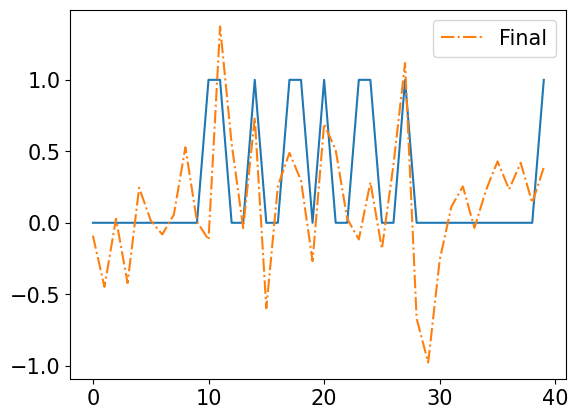

PyObject <matplotlib.legend.Legend object at 0x7fed84ced760>

In [90]:
plot(θ_ref)
plot(uki_objs.θ_mean[end], "-.", label="Final")
legend()

In [88]:
uki_objs.θ_mean[end]

40-element Array{Float64,1}:
 -0.058438248489959585
 -0.3637412235666047
  0.020414439117308718
 -0.8942105568531837
 -0.051345275385016646
 -0.0539952910348939
  0.06633720917146378
  0.1569198002444011
 -0.1148944228351377
 -0.013438062709175774
  0.021644291910773744
 -0.02909065322993569
  0.00581528018608804
  ⋮
  0.005762870508600831
 -0.6902808197154651
 -0.005300815725282168
  0.19473849894949938
  0.44150648396571357
  0.029487811141899953
 -0.004335643230021766
  0.3580796843778213
  0.0713515942727768
  0.4415324479255833
 -0.18665204799930302
  0.28727223522301004

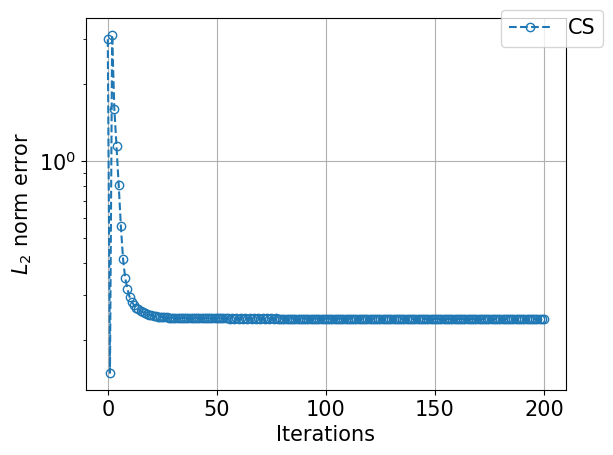

In [81]:
errors = zeros(FT, N_iter+1)
for i = 1:N_iter+1
    errors[i] = norm(uki_objs.θ_mean[i] .- θ_ref)
end


ites = Array(0:N_iter)
semilogy(ites, errors, "--o", fillstyle="none", label="CS")
xlabel("Iterations")
ylabel("\$L_2\$ norm error")
grid("on")
legend(bbox_to_anchor=(1.1, 1.05))
tight_layout()